<a href="https://colab.research.google.com/github/kartalozbalkanli/Traffic-Analysis-Project/blob/main/DSA_Project_Phase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 Accidents Per Vehicle:
   Average Forecast (2024–2030):
    2024: 0.051580
    2025: 0.050949
    2026: 0.050317
    2027: 0.049685
    2028: 0.049054
    2029: 0.048422
    2030: 0.047790


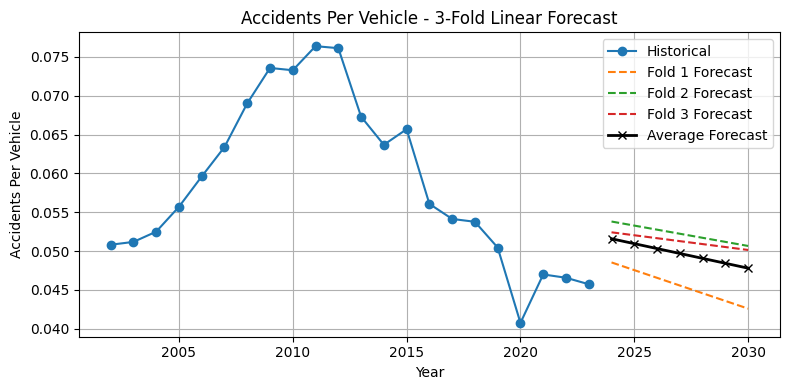

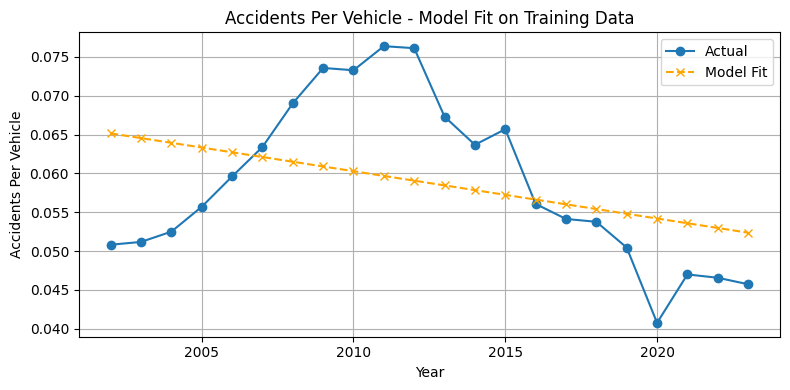

Mean forecast for accidents_per_vehicle: 0.047790
  Model Evaluation on Training Data:
    MSE: 0.000094
    R²: 0.137547
  One-tailed t-test (future mean < past mean):
    Past mean: 0.058756
    Future mean: 0.049685
    t-statistic: -17.587978
    one-tailed p-value: 0.000001
    => Reject null hypothesis: Significant decrease predicted.

 Deaths Per Accident:
   Average Forecast (2024–2030):
    2024: 0.000481
    2025: 0.000221
    2026: 0.000073
    2027: 0.000000
    2028: 0.000000
    2029: 0.000000
    2030: 0.000000


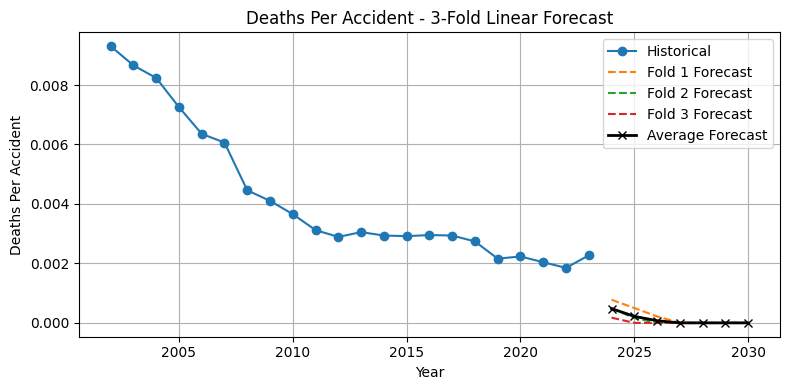

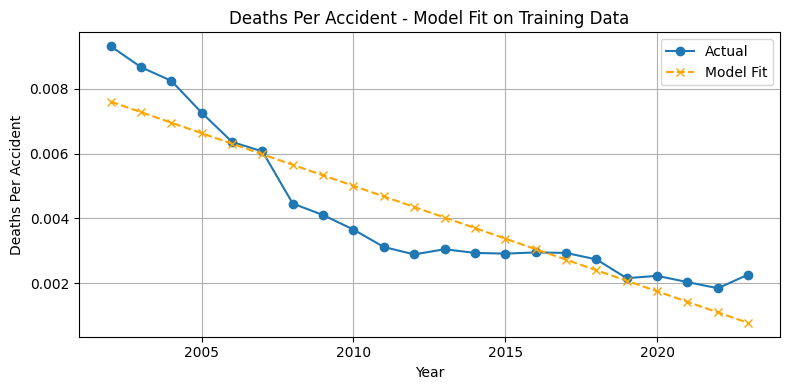

Mean forecast for deaths_per_accident: 0.000000
  Model Evaluation on Training Data:
    MSE: 0.000001
    R²: 0.812806
  One-tailed t-test (future mean < past mean):
    Past mean: 0.004192
    Future mean: 0.000111
    t-statistic: -59.206432
    one-tailed p-value: 0.000000
    => Reject null hypothesis: Significant decrease predicted.

 Injuries Per Accident:
   Average Forecast (2024–2030):
    2024: 0.237047
    2025: 0.237431
    2026: 0.237814
    2027: 0.238197
    2028: 0.238580
    2029: 0.238964
    2030: 0.239347


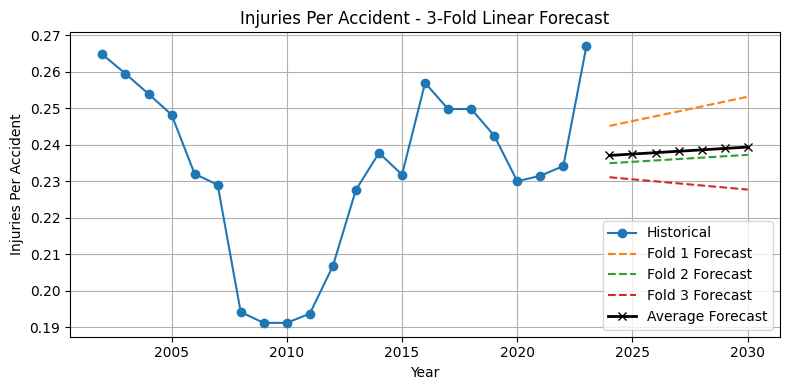

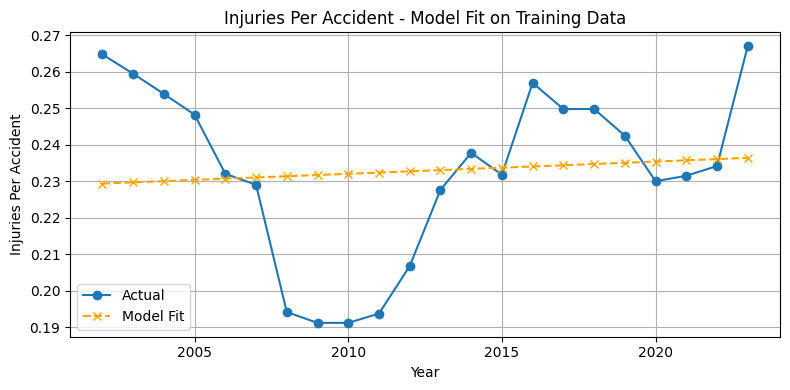

Mean forecast for injuries_per_accident: 0.239347
  Model Evaluation on Training Data:
    MSE: 0.000544
    R²: 0.008240
  One-tailed t-test (future mean < past mean):
    Past mean: 0.232863
    Future mean: 0.238197
    t-statistic: 17.048168
    one-tailed p-value: 0.999999
    => Fail to reject null hypothesis: No significant decrease predicted.

 Fault Rate:
   Average Forecast (2024–2030):
    2024: 0.877211
    2025: 0.875751
    2026: 0.874291
    2027: 0.872830
    2028: 0.871370
    2029: 0.869910
    2030: 0.868449


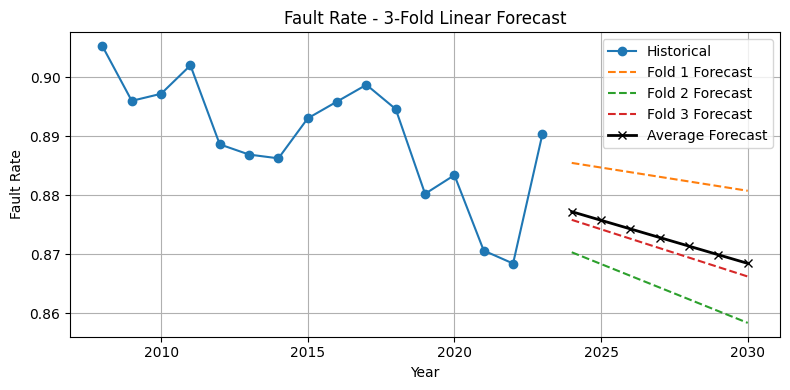

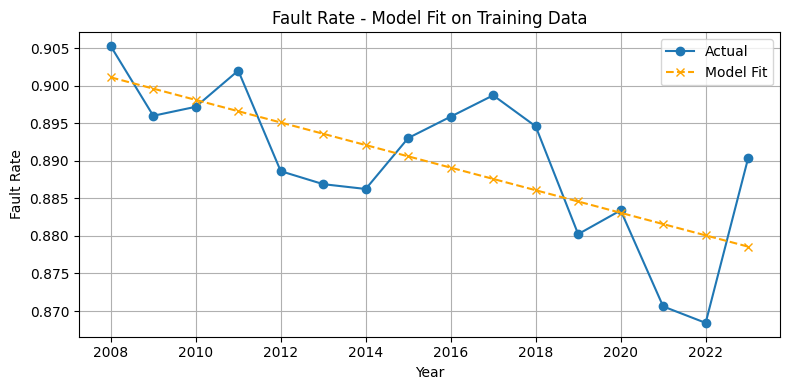

Mean forecast for fault_rate: 0.868449
  Model Evaluation on Training Data:
    MSE: 0.000053
    R²: 0.476469
  One-tailed t-test (future mean < past mean):
    Past mean: 0.889837
    Future mean: 0.872830
    t-statistic: -14.262900
    one-tailed p-value: 0.000004
    => Reject null hypothesis: Significant decrease predicted.


In [21]:
#LINEAR REGRESION

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_1samp

import pandas as pd
import numpy as np

# Load datasets
df_vehicles = pd.read_csv('vehicles_population.csv', delimiter=';')
df_accidents = pd.read_csv('accident_death.csv', delimiter=';')
df_faults = pd.read_csv('faults_data.csv', delimiter=';')

# Clean and convert relevant columns to numeric
df_vehicles['year'] = pd.to_numeric(df_vehicles['year'], errors='coerce')
df_vehicles['total_vehicle'] = pd.to_numeric(df_vehicles['total_vehicle'].astype(str).str.replace(' ', '').str.strip(), errors='coerce')

df_accidents['year'] = pd.to_numeric(df_accidents['year'], errors='coerce')
df_accidents['total_accidents'] = pd.to_numeric(df_accidents['total_accidents'].astype(str).str.replace(' ', '').str.strip(), errors='coerce')
df_accidents['dead_at_scene'] = pd.to_numeric(df_accidents['dead_at_scene'].astype(str).str.replace(' ', '').str.strip(), errors='coerce')
df_accidents['injured'] = pd.to_numeric(df_accidents['injured'].astype(str).str.replace(' ', '').str.strip(), errors='coerce')

df_faults['year'] = pd.to_numeric(df_faults['year'], errors='coerce')
df_faults['driver_faults'] = pd.to_numeric(df_faults['driver_faults'].astype(str).str.replace(' ', '').str.strip(), errors='coerce')
df_faults['total'] = pd.to_numeric(df_faults['total'].astype(str).str.replace(' ', '').str.strip(), errors='coerce')

# Calculate driver fault rate
df_faults['fault_rate'] = df_faults['driver_faults'] / df_faults['total']

# Merge all dataframes on 'year'
df = pd.merge(df_vehicles, df_accidents, on='year', how='inner')
df = pd.merge(df, df_faults[['year', 'fault_rate']], on='year', how='left')

# Calculate safety metrics
df['accidents_per_vehicle'] = df['total_accidents'] / df['total_vehicle']
df['injuries_per_accident'] = df['injured'] / df['total_accidents']
df['deaths_per_accident'] = df['dead_at_scene'] / df['total_accidents']

# Forecast range - next 7 years (2024–2030 inclusive)
future_years = pd.DataFrame({'year': np.arange(2024, 2031)})


# List of targets
targets = [
    "accidents_per_vehicle",
    "deaths_per_accident",
    "injuries_per_accident",
    "fault_rate"
]

for target in targets:
    print(f"\n {target.replace('_', ' ').title()}:")

    # Prepare data and drop NaNs
    data = df[['year', target]].dropna().reset_index(drop=True)

    # Shuffle data indices randomly for folds
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))

    fold_size = len(data) // 3 # 3 folds
    folds = [
        shuffled_indices[0:fold_size],
        shuffled_indices[fold_size:2*fold_size],
        shuffled_indices[2*fold_size:]
    ]

    all_forecasts = []

    plt.figure(figsize=(8, 4))
    plt.plot(data['year'], data[target], label="Historical", marker='o')

    for i in range(3):
        val_idx = folds[i]
        train_idx = np.setdiff1d(shuffled_indices, val_idx)

        X_train = data.loc[train_idx, ['year']].values
        y_train = data.loc[train_idx, target].values

        model = LinearRegression() # Linear regression model is used
        model.fit(X_train, y_train)

        X_future = future_years.values
        preds = model.predict(X_future)

        # Replace negative predictions with 0
        preds = np.where(preds < 0, 0, preds)

        all_forecasts.append(preds)

        plt.plot(future_years['year'], preds, linestyle='--', label=f"Fold {i+1} Forecast")

    avg_forecast = np.mean(all_forecasts, axis=0)

    print("   Average Forecast (2024–2030):")
    for year, pred in zip(future_years['year'], avg_forecast):
        print(f"    {year}: {pred:.6f}")

    plt.plot(future_years['year'], avg_forecast, color='black', marker='x', linewidth=2, label="Average Forecast")
    plt.title(f"{target.replace('_', ' ').title()} - 3-Fold Linear Forecast")
    plt.xlabel("Year")
    plt.ylabel(target.replace('_', ' ').title())
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Model fit on all data (self-prediction) ---
    X_all = data[['year']].values
    y_all = data[target].values

    full_model = LinearRegression()
    full_model.fit(X_all, y_all)

    y_pred_all = full_model.predict(X_all)

    plt.figure(figsize=(8, 4))
    plt.plot(data['year'], y_all, label="Actual", marker='o')
    plt.plot(data['year'], y_pred_all, label="Model Fit", linestyle='--', marker='x', color='orange')
    plt.title(f"{target.replace('_', ' ').title()} - Model Fit on Training Data")
    plt.xlabel("Year")
    plt.ylabel(target.replace('_', ' ').title())
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"Mean forecast for {target}: {np.mean(pred):.6f}")

    # Calculate and print evaluation metrics
    mse = mean_squared_error(y_all, y_pred_all)
    r2 = r2_score(y_all, y_pred_all)

    print(f"  Model Evaluation on Training Data:")
    print(f"    MSE: {mse:.6f}")
    print(f"    R²: {r2:.6f}")

    # --- One-tailed t-test for decrease in predicted future mean vs past mean ---
    past_mean = np.mean(y_all)
    future_mean = np.mean(avg_forecast)

    t_stat, p_val_two_tailed = ttest_1samp(avg_forecast, past_mean)

    # One-tailed test for decrease: H0: future_mean >= past_mean vs H1: future_mean < past_mean
    if t_stat < 0:
        p_val_one_tailed = p_val_two_tailed / 2
    else:
        p_val_one_tailed = 1 - (p_val_two_tailed / 2)

    print(f"  One-tailed t-test (future mean < past mean):")
    print(f"    Past mean: {past_mean:.6f}")
    print(f"    Future mean: {future_mean:.6f}")
    print(f"    t-statistic: {t_stat:.6f}")
    print(f"    one-tailed p-value: {p_val_one_tailed:.6f}")

    if p_val_one_tailed < 0.05:
        print("    => Reject null hypothesis: Significant decrease predicted.")
    else:
        print("    => Fail to reject null hypothesis: No significant decrease predicted.")


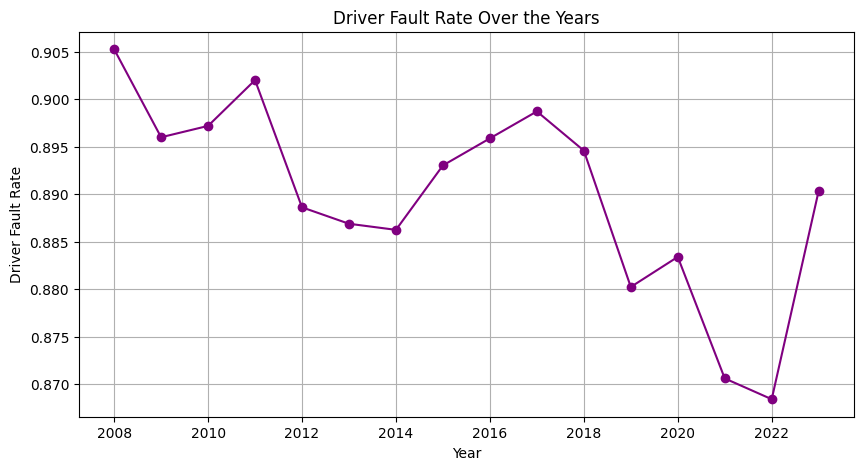

FAULT RATE STATISTICS:
Minimum fault rate: 0.8684
Maximum fault rate: 0.9053
Mean before 2015: 0.8946
Mean after 2015: 0.8861
Difference between means: -0.0085
Std dev before 2015: 0.0075
Std dev after 2015: 0.0111

HYPOTHESIS TESTING ON FAULT RATE:
t-statistic = 1.8105, p-value = 0.0460
→ Significant decrease after 2015 → Reject H₀


In [14]:
#EDA For the Fault Rate Indicator

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

# Load data
df1 = pd.read_csv('vehicles_population.csv', delimiter=';')
df2 = pd.read_csv('accident_death.csv', delimiter=';')
df3 = pd.read_csv('faults_data.csv', delimiter=';')

# Clean and convert to numeric
df1['year'] = pd.to_numeric(df1['year'], errors='coerce')
df1['total_vehicle'] = pd.to_numeric(df1['total_vehicle'].astype(str).str.replace(' ', '').str.strip(), errors='coerce')

df2['year'] = pd.to_numeric(df2['year'], errors='coerce')
df2['total_accidents'] = pd.to_numeric(df2['total_accidents'].astype(str).str.replace(' ', '').str.strip(), errors='coerce')
df2['dead_at_scene'] = pd.to_numeric(df2['dead_at_scene'].astype(str).str.replace(' ', '').str.strip(), errors='coerce')
df2['injured'] = pd.to_numeric(df2['injured'].astype(str).str.replace(' ', '').str.strip(), errors='coerce')

df3['year'] = pd.to_numeric(df3['year'], errors='coerce')
df3['driver_faults'] = pd.to_numeric(df3['driver_faults'].astype(str).str.replace(' ', '').str.strip(), errors='coerce')
df3['total'] = pd.to_numeric(df3['total'].astype(str).str.replace(' ', '').str.strip(), errors='coerce')

# Compute fault rate
df3['fault_rate'] = df3['driver_faults'] / df3['total']

# Merge data
df = pd.merge(df1, df2, on='year', how='inner')
df = pd.merge(df, df3[['year', 'fault_rate']], on='year', how='left')

# --- Plot fault rate ---
plt.figure(figsize=(10, 5))
plt.plot(df['year'], df['fault_rate'], marker='o', color='purple')
plt.title('Driver Fault Rate Over the Years')
plt.xlabel('Year')
plt.ylabel('Driver Fault Rate')
plt.xticks(np.arange(2008, 2024, 2))
plt.grid(True)
plt.show()

# --- Statistics for fault rate ---
min_fault = df['fault_rate'].min()
max_fault = df['fault_rate'].max()

before_fault = df[df['year'] < 2015]['fault_rate'].dropna()
now_fault = df[df['year'] >= 2015]['fault_rate'].dropna()

mean_before = before_fault.mean()
mean_now = now_fault.mean()
std_before = before_fault.std()
std_now = now_fault.std()

print("FAULT RATE STATISTICS:")
print(f"Minimum fault rate: {min_fault:.4f}")
print(f"Maximum fault rate: {max_fault:.4f}")
print(f"Mean before 2015: {mean_before:.4f}")
print(f"Mean after 2015: {mean_now:.4f}")
print(f"Difference between means: {mean_now - mean_before:.4f}")
print(f"Std dev before 2015: {std_before:.4f}")
print(f"Std dev after 2015: {std_now:.4f}\n")

# --- Hypothesis test ---
t_stat, p_val = ttest_ind(before_fault, now_fault, equal_var=False, alternative='greater')

print("HYPOTHESIS TESTING ON FAULT RATE:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")
if p_val < 0.05:
    print("→ Significant decrease after 2015 → Reject H₀")
else:
    print("→ No significant decrease → Fail to reject H₀")



 Accidents Per Vehicle:
   Average Forecast (2024–2028):
    2024: 0.041352
    2025: 0.041166
    2026: 0.041805
    2027: 0.043377
    2028: 0.045986
   One-tailed T-Test (historical > forecast):
    Historical Mean: 0.059377
    Forecast Mean:   0.042737
    t-statistic:     6.7507
    p-value:         0.0000002890
     Significant decrease detected (p < 0.05)
   Cross-Validation Metrics (averaged over folds):
    Mean MSE: 0.000068
    Mean R²:  0.208302


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


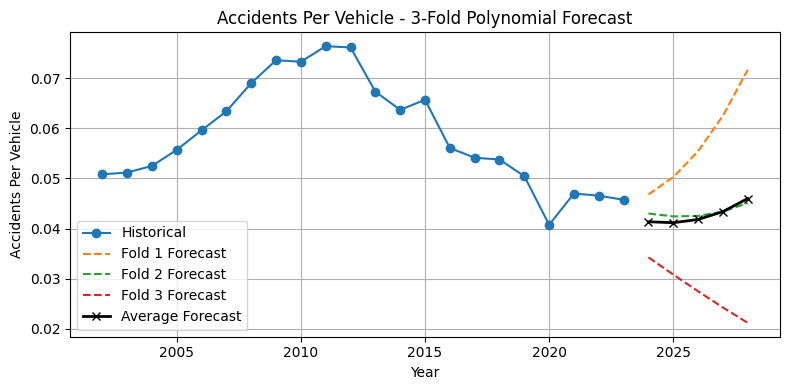

   Full model fit metrics on all training data:
    MSE: 0.000018
    R²:  0.836053


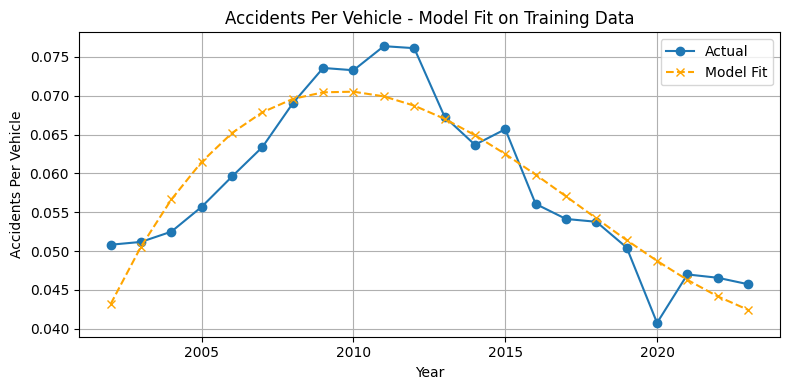

Mean forecast for accidents_per_vehicle: 0.0460

 Deaths Per Accident:
   Average Forecast (2024–2028):
    2024: 0.001776
    2025: 0.001536
    2026: 0.001237
    2027: 0.000870
    2028: 0.000427
   One-tailed T-Test (historical > forecast):
    Historical Mean: 0.004283
    Forecast Mean:   0.001169
    t-statistic:     5.4920
    p-value:         0.0000060342
     Significant decrease detected (p < 0.05)
   Cross-Validation Metrics (averaged over folds):
    Mean MSE: 0.000000
    Mean R²:  0.935538


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


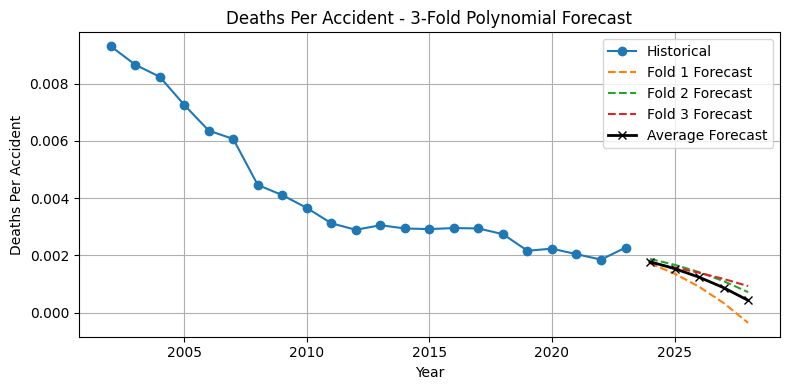

   Full model fit metrics on all training data:
    MSE: 0.000000
    R²:  0.978317


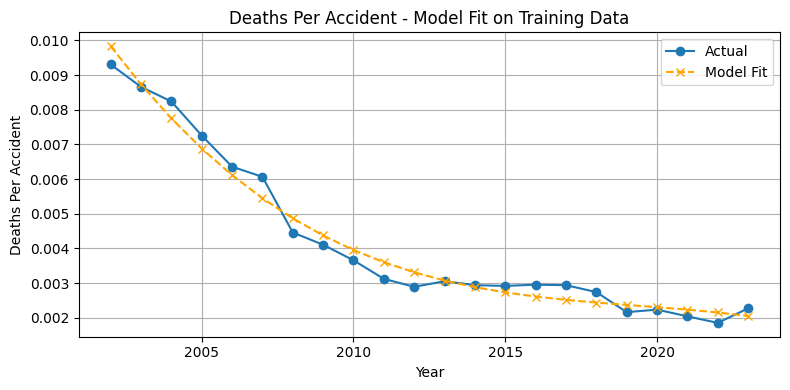

Mean forecast for deaths_per_accident: 0.0004

 Injuries Per Accident:
   Average Forecast (2024–2028):
    2024: 0.230008
    2025: 0.217675
    2026: 0.201501
    2027: 0.181114
    2028: 0.156138
   One-tailed T-Test (historical > forecast):
    Historical Mean: 0.231238
    Forecast Mean:   0.197287
    t-statistic:     2.4080
    p-value:         0.0292641875
     Significant decrease detected (p < 0.05)
   Cross-Validation Metrics (averaged over folds):
    Mean MSE: 0.000434
    Mean R²:  -0.830775


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


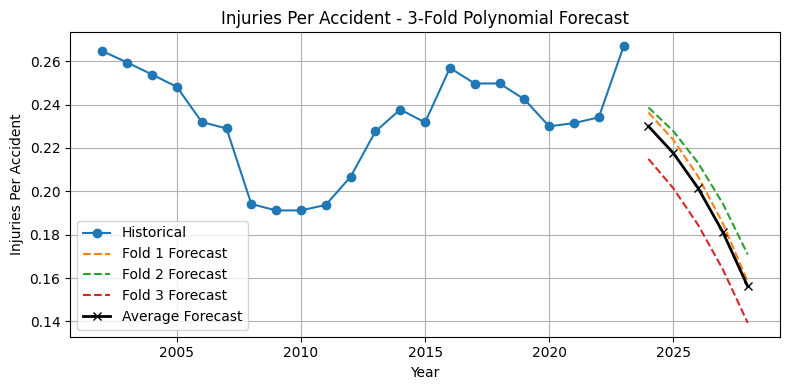

   Full model fit metrics on all training data:
    MSE: 0.000210
    R²:  0.617154


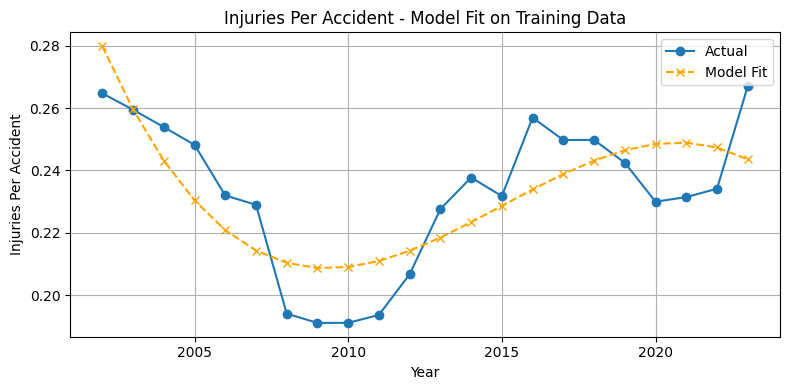

Mean forecast for injuries_per_accident: 0.1561

 Fault Rate:
   Average Forecast (2024–2028):
    2024: 0.867954
    2025: 0.861686
    2026: 0.854324
    2027: 0.845767
    2028: 0.835915
   One-tailed T-Test (historical > forecast):
    Historical Mean: 0.889803
    Forecast Mean:   0.853129
    t-statistic:     5.8049
    p-value:         0.0005631860
     Significant decrease detected (p < 0.05)
   Cross-Validation Metrics (averaged over folds):
    Mean MSE: 0.000163
    Mean R²:  -1.759208


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


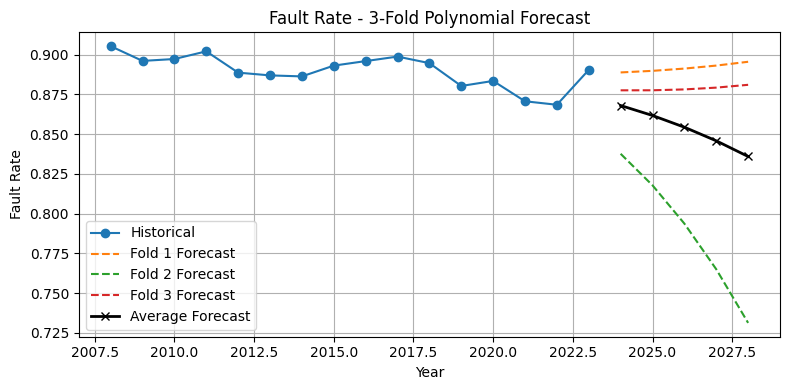

   Full model fit metrics on all training data:
    MSE: 0.000052
    R²:  0.481239


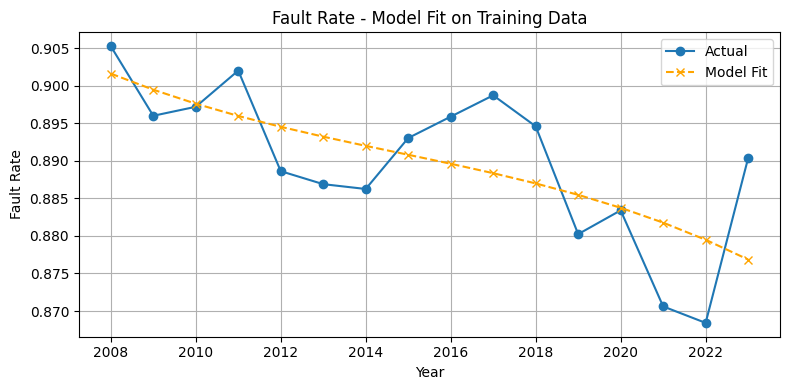

Mean forecast for fault_rate: 0.8359


In [20]:
# POLYNOMIAL REGRESSION WITH T-TEST

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_ind

# Load main datasets
df1 = pd.read_csv('vehicles_population.csv', delimiter=';')
df2 = pd.read_csv('accident_death.csv', delimiter=';')

# Merge dataframes on year
df = pd.merge(df1, df2, on='year')

# Convert columns to numeric
cols_to_numeric = ['total_vehicle', 'total_accidents', 'dead_at_scene', 'injured', 'year']
for col in cols_to_numeric:
    df[col] = df[col].astype(str).str.replace(' ', '').str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculate Safety Metrics
df['accidents_per_vehicle'] = df['total_accidents'] / df['total_vehicle']
df['injuries_per_accident'] = df['injured'] / df['total_accidents']
df['deaths_per_accident'] = df['dead_at_scene'] / df['total_accidents']

# Load fault data and compute fault_rate
df_fault = pd.read_csv("faults_data.csv", delimiter=';')
df_fault['year'] = pd.to_numeric(df_fault['year'], errors='coerce')
df_fault['total'] = pd.to_numeric(df_fault['total'], errors='coerce')
df_fault['driver_faults'] = pd.to_numeric(df_fault['driver_faults'], errors='coerce')
df_fault['fault_rate'] = df_fault['driver_faults'] / df_fault['total']

# Merge fault_rate into main df on year (left join)
df = pd.merge(df, df_fault[['year', 'fault_rate']], on='year', how='left')

# Forecast range
future_years = pd.DataFrame({'year': np.arange(2024, 2029)})

# List of targets
targets = [
    "accidents_per_vehicle",
    "deaths_per_accident",
    "injuries_per_accident",
    "fault_rate"
]

degree = 3  # Polynomial degree is determined as 3

for target in targets:
    print(f"\n {target.replace('_', ' ').title()}:")
    # Prepare data, drop NaNs
    data = df[['year', target]].dropna().reset_index(drop=True)

    # Shuffle data indices randomly for folds
    np.random.seed(42)  # For reproducibility
    shuffled_indices = np.random.permutation(len(data))

    fold_size = len(data) // 3
    folds = [
        shuffled_indices[0:fold_size],
        shuffled_indices[fold_size:2*fold_size],
        shuffled_indices[2*fold_size:]
    ]

    all_forecasts = []
    all_fold_mse = []
    all_fold_r2 = []

    plt.figure(figsize=(8, 4))
    plt.plot(data['year'], data[target], label="Historical", marker='o')

    for i in range(3):
        # Validation indices for this fold
        val_idx = folds[i]
        # Training indices are all others
        train_idx = np.setdiff1d(shuffled_indices, val_idx)

        # Training data
        X_train = data.loc[train_idx, ['year']].values
        y_train = data.loc[train_idx, target].values

        # Validation data
        X_val = data.loc[val_idx, ['year']].values
        y_val = data.loc[val_idx, target].values

        # Transform features to polynomial
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Train model
        model = LinearRegression()
        model.fit(X_train_poly, y_train)

        # Predict on validation fold
        y_val_pred = model.predict(X_val_poly)
        mse_val = mean_squared_error(y_val, y_val_pred)
        r2_val = r2_score(y_val, y_val_pred)

        all_fold_mse.append(mse_val)
        all_fold_r2.append(r2_val)

        # Predict future years
        X_future_poly = poly.transform(future_years)
        preds = model.predict(X_future_poly)
        all_forecasts.append(preds)

        # Plot fold forecast
        plt.plot(future_years['year'], preds, linestyle='--', label=f"Fold {i+1} Forecast")

    # Average forecast across folds
    avg_forecast = np.mean(all_forecasts, axis=0)

    print("   Average Forecast (2024–2028):")
    for year, pred in zip(future_years['year'], avg_forecast):
        print(f"    {year}: {pred:.6f}")

    # One-tailed t-test (checking for significant decrease)
    historical_values = data[data['year'] < 2023][target].dropna().values
    forecast_values = avg_forecast

    t_stat, p_val = ttest_ind(historical_values, forecast_values, equal_var=False, alternative='greater')

    print("   One-tailed T-Test (historical > forecast):")
    print(f"    Historical Mean: {np.mean(historical_values):.6f}")
    print(f"    Forecast Mean:   {np.mean(forecast_values):.6f}")
    print(f"    t-statistic:     {t_stat:.4f}")
    print(f"    p-value:         {p_val:.10f}")
    if p_val < 0.05:
        print("     Significant decrease detected (p < 0.05)")
    else:
        print("     No significant decrease (p ≥ 0.05)")

    print(f"   Cross-Validation Metrics (averaged over folds):")
    print(f"    Mean MSE: {np.mean(all_fold_mse):.6f}")
    print(f"    Mean R²:  {np.mean(all_fold_r2):.6f}")

    plt.plot(future_years['year'], avg_forecast, color='black', marker='x', linewidth=2, label="Average Forecast")
    plt.title(f"{target.replace('_', ' ').title()} - 3-Fold Polynomial Forecast")
    plt.xlabel("Year")
    plt.ylabel(target.replace('_', ' ').title())
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Model fit on all data (self-prediction) ---

    X_all = data[['year']].values
    y_all = data[target].values

    poly_full = PolynomialFeatures(degree=degree)
    X_all_poly = poly_full.fit_transform(X_all)

    full_model = LinearRegression()
    full_model.fit(X_all_poly, y_all)

    y_pred_all = full_model.predict(X_all_poly)

    mse_all = mean_squared_error(y_all, y_pred_all)
    r2_all = r2_score(y_all, y_pred_all)

    print(f"   Full model fit metrics on all training data:")
    print(f"    MSE: {mse_all:.6f}")
    print(f"    R²:  {r2_all:.6f}")

    plt.figure(figsize=(8, 4))
    plt.plot(data['year'], y_all, label="Actual", marker='o')
    plt.plot(data['year'], y_pred_all, label="Model Fit", linestyle='--', marker='x', color='orange')
    plt.title(f"{target.replace('_', ' ').title()} - Model Fit on Training Data")
    plt.xlabel("Year")
    plt.ylabel(target.replace('_', ' ').title())
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Mean forecast for {target}: {np.mean(pred):.4f}")
